In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
print(f'{torchvision.__version__=}')

import matplotlib.pyplot as plt
import numpy as np


torchvision.__version__='0.23.0'


In [3]:
# print("GPU name:", torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print(torch.cuda.device_count(), "GPUs available")

Device: cpu
0 GPUs available


# Load MNIST Dataset

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 19.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.27MB/s]


Training dataset 60000 samples
Test dataset 10000 samples


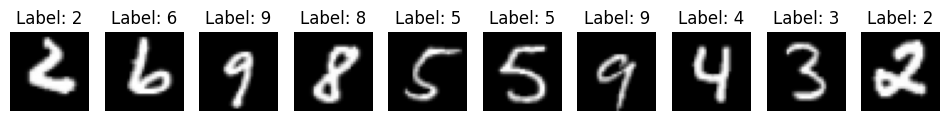

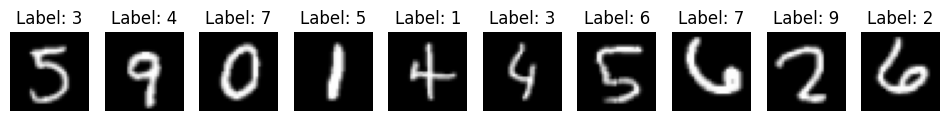

In [4]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(0.5,))])
training_data = datasets.MNIST(root='./data_src', train=True, download=True,transform=transform)
test_data = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

# show random samples from the dataset
print(f"Training dataset {len(training_data)} samples")
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for ax in axes.ravel():
    idx = np.random.randint(len(training_data))
    ax.imshow(training_data[idx][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {training_data[idx][1]}')
    ax.axis('off')

print(f"Test dataset {len(test_data)} samples")
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for ax in axes.ravel():
    idx = np.random.randint(len(test_data))
    ax.imshow(test_data[idx][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {training_data[idx][1]}')
    ax.axis('off')

In [5]:
# Define dataloaders
training_dataloader = DataLoader(training_data,
                                 batch_size=64,
                                 shuffle=True,
                                 drop_last=True)
test_dataloader = DataLoader(test_data,
                             batch_size=64,
                             shuffle=False,
                             drop_last=True)

In [6]:
# Say we want 1000 diffusion steps
T = 1000
# Create a beta schedule that goes from 1e-4 to 0.02
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0) # cumulative product

def q_sample(x_0, t, noise=None):
    """
    Forward diffusion (adding noise) step
    x0: original image [batch, 1, 28, 28]
    t: timestep [batch]
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise

# Forward process in action where we corrupt the images

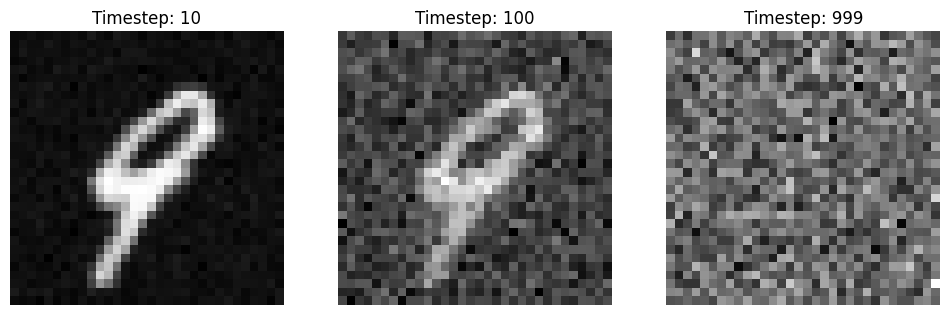

In [24]:
# when t is small, x_t is similar to x_0
# when t is large, x_t is similar to random noise

images = next(iter(training_dataloader))[0] # get images
timesteps = [10, 100, 999]
noisy_images = []
for timestep in timesteps:
    t = torch.full((images.shape[0], ), timestep, dtype=torch.long)
    noisy_images.append(q_sample(images, t)) # get noisy images at timestep

# plot noisy images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for t, ax, noisy_images in zip(timesteps, axes.ravel(), noisy_images):
    ax.imshow(noisy_images[63].squeeze(), cmap='gray') # plot last (63) image of the batch
    ax.axis('off')
    ax.set_title(f'Timestep: {t}')

### For the reverse process, we train a neural network to predict the noise that was added at $t$


$$
\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

where,
- $x_0$ is the original image,
- $x_t$ is the noisy image at timestep $t$,
- $\epsilon$ is the noise added to the image,
- $\epsilon_\theta(x_t, t)$ is the predicted noise by the neural network.

So the network job is to: "Given the noisy image at timestep $t$, predict the noise $\epsilon$ that was added to obtain it."


In [22]:
print(images.shape)

torch.Size([64, 1, 32, 32])


We write a simple CNN model, where:

Input to the model: a noisy image $x_t$ and timestep $t$

Output of the model: the model's guess for the noise we added (same shape as $x_t$)

In [32]:
class SimpleDiffusionModel(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        # We learn a 64-dimensional embedding for each timestep 0 to T - 1
        self.time_embed = nn.Embedding(T, 64) # 64 because we add it after conv2
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        # t is [batch], get embedding and broadcast to image
        t_embed = self.time_embed(t)
        t_embed = t_embed[:, :, None, None] # [batch, 32, 1, 1]

        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))

        # Inject time info
        h = h + t_embed
        h = F.relu(self.conv3(h))
        out = self.conv4(h)
        return out # predicted noise

In [34]:
model = SimpleDiffusionModel(T=1000)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    for x0, _ in training_dataloader:
        t = torch.randint(0, T, (x0.shape[0],))

        actual_noise = torch.randn_like(x0)
        xt = q_sample(x0, t, actual_noise)  # noisy image
        predicted_noise = model(xt, t)

        loss = F.mse_loss(predicted_noise, actual_noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch", epoch, "loss", loss.item())

epoch 0 loss 0.04576260596513748


KeyboardInterrupt: 